<a href="https://colab.research.google.com/github/parth2102/CE888-7-SP-Data-Science-and-Decision-Making/blob/main/Labs/lab6/my_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
np.set_printoptions(precision = 3)
import pandas as pd
import operator
import matplotlib.pyplot as plt
from IPython.display import Image

In [ ]:
ratings = pd.read_csv('https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv', header=None )
print(ratings)

       0      1      2      3      4     5      6     7     8      9    ...  \
0       74  -7.82   8.79  -9.66  -8.16 -7.52  -8.50 -9.85  4.17  -8.98  ...   
1      100   4.08  -0.29   6.36   4.37 -2.38  -9.66 -0.73 -5.34   8.88  ...   
2       49  99.00  99.00  99.00  99.00  9.03   9.27  9.03  9.27  99.00  ...   
3       48  99.00   8.35  99.00  99.00  1.80   8.16 -2.82  6.21  99.00  ...   
4       91   8.50   4.61  -4.17  -5.39  1.36   1.60  7.04  4.61  -0.44  ...   
...    ...    ...    ...    ...    ...   ...    ...   ...   ...    ...  ...   
24978  100   0.44   7.43   9.08   2.33  3.20   6.75 -8.79 -0.53  -8.74  ...   
24979   91   9.13  -8.16   8.59   9.08  0.87  -8.93 -3.50  5.78  -8.11  ...   
24980   39  99.00  99.00  99.00  99.00 -7.77  99.00  6.70 -6.75  99.00  ...   
24981   37  99.00  99.00  99.00  99.00 -9.71  99.00  4.56 -8.30  99.00  ...   
24982   72   2.43   2.67  -3.98   4.27 -2.28   7.33  2.33  4.56   6.75  ...   

         91     92     93     94     95     96     

In [ ]:
ratings.drop(columns=[0],axis=1, inplace=True)
ratings = ratings.replace(99.00, np.NaN)
ratings.head()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,...,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,...,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,1.84,...,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [ ]:
mean_rating = ratings.mean(axis=0)
(pd.DataFrame(mean_rating)).nlargest(10,0)
ratings.iloc[5621, 17]

arr = ratings.values
print(arr.shape)
rated = np.where(~np.isnan(arr))
print(len(rated[0]), rated[1].shape)

(24983, 100)
1810455 (1810455,)


In [ ]:
def replace(orig, percentage=0.1):
  ndata = orig.copy()
  rated = np.where(~np.isnan(arr))
  n_rated = len(rated[0])
  idx = np.random.choice(n_rated, size=int(percentage*n_rated), replace=False)
  ndata[rated[0][idx], rated[1][idx]] = 99
  return ndata, (rated[0][idx], rated[1][idx])

n_arr, idx = replace(arr, 0.1)
print(arr[idx[0][0], idx[1][0]])
n_arr[idx[0][0], idx[1][0]]

5.83


99.0

In [ ]:
n_latent_factors = 2
latent_u_preferences = np.random.random((arr.shape[0], n_latent_factors))
latent_i_features = np.random.random((arr.shape[1], n_latent_factors))

def predict(u_id, i_id):
    u_preference = latent_u_preferences[u_id]
    i_preference = latent_i_features[i_id]
    return u_preference.dot(i_preference)

def train(u_id, i_id, rating, alpha=0.0001):
    predicted_r = predict(u_id, i_id)
    error =  predicted_r - rating
    upref_values = latent_u_preferences[u_id]
    latent_u_preferences[u_id] -= alpha * error * latent_i_features[i_id]
    latent_i_features[i_id] -= alpha * error * upref_values
    return error

def sgd(iterations):
    mse_history = []
    for iter in range(iterations):
        error = []
        for u_id in range(latent_u_preferences.shape[0]):
            for i_id in range(latent_i_features.shape[0]):
                rating = arr[u_id, i_id]
                if (~np.isnan(rating)) and rating!=99 :
                    err = train(u_id, i_id, rating)
                    error.append(err)
        mse = (np.array(error) ** 2).mean()   
        if (iter % 10) == 0:
            print('Iteration %d/%d:\tMSE=%.6f' % (iter, iterations, mse))
            mse_history.append(mse)
    return mse_history

In [ ]:
predictions = latent_u_preferences.dot(latent_i_features.T)
predictions
values = [zip(arr[i], predictions[i]) for i in range(predictions.shape[0])]
comparison_data = pd.DataFrame(values)
comparison_data.columns = ratings.columns
comparison_data

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,"(-7.82, -3.918562068790458)","(8.79, -4.167187699072545)","(-9.66, -5.645924925219583)","(-8.16, -9.549162258852094)","(-7.52, -2.675924663441368)","(-8.5, -1.7712506028088442)","(-9.85, -4.914852434258823)","(4.17, -4.319524797331706)","(-8.98, -8.853186950925021)","(-4.76, -3.730932593853676)",...,"(2.82, -1.5547921968897869)","(nan, -3.248980166992082)","(nan, 0.18648064555675234)","(nan, -4.788440838315077)","(nan, -3.985328141729372)","(nan, -2.923871826878532)","(-5.63, -2.2232196097137282)","(nan, -2.4565166788560577)","(nan, -6.224951229400491)","(nan, -2.5834962173520126)"
1,"(4.08, 2.986007928983959)","(-0.29, 3.144785503286627)","(6.36, 3.7890197382083572)","(4.37, 5.267441959246491)","(-2.38, 2.2099025657741955)","(-9.66, 2.517056290514669)","(-0.73, 2.97016557076622)","(-5.34, 2.327221771776247)","(8.88, 5.075128162187686)","(9.22, 2.993101698624169)",...,"(2.82, 2.2248483525170033)","(-4.95, 2.9322134253935763)","(-0.29, 1.6105726740769983)","(7.86, 3.487886956570185)","(-0.19, 3.076468572944609)","(-2.14, 2.781855762687926)","(3.06, 2.4298792651116137)","(0.34, 2.5092074329154874)","(-4.32, 3.962320660819239)","(1.07, 2.755959976396097)"
2,"(nan, 6.88006490674399)","(nan, 7.171134021430465)","(nan, 7.479365545706127)","(nan, 7.240013214603526)","(9.03, 5.508119691373368)","(9.27, 8.64454937124139)","(9.03, 4.954675758370774)","(9.27, 3.0119246599568994)","(nan, 7.620742084246914)","(nan, 7.262157419785076)",...,"(nan, 7.661110401698085)","(nan, 7.868534857169492)","(nan, 7.982492731040666)","(9.08, 7.6441022746590965)","(nan, 7.184968006495871)","(nan, 7.759427911815303)","(nan, 7.391837871479526)","(nan, 7.33468321017669)","(nan, 7.22568508235137)","(nan, 8.268782745769656)"
3,"(nan, 1.8116244476452368)","(8.35, 1.86163385969473)","(nan, 1.523848220586872)","(nan, 0.16218392833818474)","(1.8, 1.598650801190949)","(8.16, 3.289635225026609)","(-2.82, 0.6318139661153354)","(6.21, -0.044073364379728926)","(nan, 0.5558893747783396)","(1.84, 2.0425154886418575)",...,"(nan, 2.9202003287360436)","(nan, 2.468149728507998)","(nan, 3.6234551188794666)","(0.53, 1.8730534006229265)","(nan, 1.926273819368828)","(nan, 2.523958658337893)","(nan, 2.585106779719059)","(nan, 2.484591670879136)","(nan, 1.2244558983037819)","(nan, 2.8607663895547795)"
4,"(8.5, 2.9103994785609046)","(4.61, 3.000554607630778)","(-4.17, 2.6122778951377006)","(-5.39, 0.9032889759621856)","(1.36, 2.513613755964705)","(1.6, 4.9114117985089925)","(7.04, 1.2629517205538596)","(4.61, 0.23768508036781438)","(-0.44, 1.4276455978833107)","(5.73, 3.2333213072725004)",...,"(5.19, 4.358621258218915)","(5.58, 3.819101142055172)","(4.27, 5.260447005438157)","(5.19, 3.060584567068066)","(5.73, 3.0819223379375402)","(1.55, 3.877606876345011)","(3.11, 3.9176418691160624)","(6.55, 3.7876566420871987)","(1.8, 2.2170101617071776)","(1.6, 4.344003769435121)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24978,"(0.44, 2.2984067988491983)","(7.43, 2.3515231264162053)","(9.08, 1.7604733513035582)","(2.33, -0.470785279413019)","(3.2, 2.085722146595158)","(6.75, 4.566633849795196)","(-8.79, 0.5406060986426108)","(-0.53, -0.38063272071211085)","(-8.74, 0.1425333972777182)","(7.23, 2.641871238095411)",...,"(8.83, 4.055078813400387)","(-1.21, 3.285035966056547)","(9.22, 5.18725183806563)","(-6.7, 2.3221340804560526)","(8.45, 2.457191412551104)","(9.03, 3.3886314735283105)","(6.55, 3.5274718406506107)","(8.69, 3.3667980672178643)","(8.79, 1.2904157998093528)","(7.43, 3.8945574164133596)"
24979,"(9.13, 2.378438462727686)","(-8.16, 2.5304214511356706)","(8.59, 3.4448825113131756)","(9.08, 5.866455410579832)","(0.87, 1.618211165647302)","(-8.93, 1.0341723695678675)","(-3.5, 3.0103211705897572)","(5.78, 2.6556121868044134)","(-8.11, 5.432172273256305)","(4.9, 2.2592931157126945)",...,"(-1.17, 0.9072501798796136)","(-5.73, 1.95602473354933)","(-1.46, -0.17462408777791857)","(0.24, 2.91

Iteration 0/100:	MSE=22.932307
Iteration 10/100:	MSE=21.152322
Iteration 20/100:	MSE=19.426260
Iteration 30/100:	MSE=17.550978
Iteration 40/100:	MSE=17.227395
Iteration 50/100:	MSE=17.158697
Iteration 60/100:	MSE=17.138558
Iteration 70/100:	MSE=17.132304
Iteration 80/100:	MSE=17.130527
Iteration 90/100:	MSE=17.130275


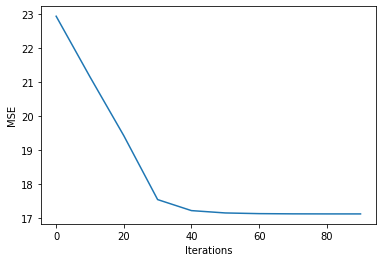

In [ ]:
num_iter = 100
hist = sgd(num_iter)
plt.figure()
plt.plot(np.arange(0, num_iter, 10), hist)
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.show()

**Movie**

In [ ]:
df1 = pd.ExcelFile('https://github.com/albanda/CE888/blob/master/lab4-recommender/movies_latent_factors.xlsx?raw=true')
df_i = pd.read_excel('https://github.com/albanda/CE888/blob/master/lab4-recommender/movies_latent_factors.xlsx?raw=true',sheet_name='Items',index_col=None)
df_u = pd.read_excel('https://github.com/albanda/CE888/blob/master/lab4-recommender/movies_latent_factors.xlsx?raw=true',sheet_name='Users', index_col=None)

In [ ]:
df_i.head()

,Movie ID,Title,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
0,11,Star Wars: Episode IV - A New Hope (1977),-1.521848,-1.038507,2.027269,0.247933,-0.594548,2.513260,-1.848910,0.476710,-0.224146,-0.760681,-0.973915,0.862379,0.403861,1.129616,-0.248806
1,12,Finding Nemo (2003),-0.342185,-0.296586,-0.385962,2.443297,-1.097015,-0.619465,0.572887,0.329516,-0.712228,0.323554,-0.561948,-0.142405,-0.564415,0.506876,1.274993
2,13,Forrest Gump (1994),-2.240888,-0.438815,-2.275177,0.614548,0.904469,0.711919,-0.420876,1.302036,-0.868418,-0.160122,0.633667,0.133138,-0.330276,-2.209004,-0.419092
3,14,American Beauty (1999),-0.634531,2.186059,-0.066681,0.086197,0.517558,-0.185319,-0.412352,0.063841,0.075937,-0.577682,0.526803,-1.465557,-0.819682,0.549010,-0.681191
4,22,Pirates of the Caribbean: The Curse of the Bla...,0.517348,-1.456763,0.369161,0.073903,-0.098332,-0.594722,0.828888,0.033626,-0.707414,0.717877,1.394326,-0.786986,1.429191,0.855746,-2.292566


In [ ]:
num_factors = df_u.shape[1]-1
u_pref = df_u[df_u['User'] == 3519].iloc[:, -num_factors:].values[0]
i_feat = df_i.iloc[:, -num_factors:].values
pref = i_feat.dot(u_pref)
pref

array([ 0.485, -0.082,  0.02 ,  0.14 , -0.177,  0.113,  0.084,  0.067,
        0.093,  0.258, -0.045,  0.178,  0.034,  0.017,  0.046,  0.021,
        0.04 ,  0.121,  0.062,  0.08 ,  0.116,  0.041, -0.065, -0.006,
       -0.086,  0.199, -0.036,  0.198,  0.072,  0.073,  0.061,  0.159,
        0.21 ,  0.113,  0.087,  0.016,  0.063, -0.128,  0.12 , -0.03 ,
        0.011,  0.035, -0.008, -0.019,  0.119,  0.027, -0.095,  0.008,
        0.156, -0.148,  0.034, -0.334, -0.178,  0.15 , -0.058,  0.041,
       -0.083, -0.06 , -0.071,  0.246,  0.028, -0.11 ,  0.067, -0.185,
        0.024, -0.222, -0.261, -0.042, -0.512,  0.07 , -0.051, -0.008,
       -0.087,  0.014, -0.039, -0.204, -0.141,  0.503,  0.449, -0.022,
        0.058, -0.116, -0.017,  0.005, -0.016, -0.533, -0.069,  0.074,
       -0.041, -0.076, -0.545, -0.058,  0.015, -0.097, -0.079, -0.073,
       -0.017, -0.074, -0.057, -0.061])

In [ ]:
df_fact = df_i[['Movie ID','Factor2']]
df_fact.sort_values('Factor2')

,Movie ID,Factor2
16,122,-2.526300
15,121,-2.512933
14,120,-2.510061
51,604,-2.004450
79,1894,-1.711204
...,...,...
6,38,1.771799
32,275,1.777301
5,24,1.997440
59,680,2.085395


In [ ]:
top_val = pd.DataFrame(pref).nlargest(3, 0)
top_indc = top_val.index
list(top_indc)

[77, 0, 78]

In [ ]:
df_fact = df_i[['Movie ID','Factor1']]

val = df_fact[df_fact['Movie ID']==36955]['Factor1'].values[0]

round(val,3)

1.734

In [ ]:
df_i.iloc[list(top_indc)]

,Movie ID,Title,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
77,1891,Star Wars: Episode V - The Empire Strikes Back...,-1.732354,-1.031041,2.221631,0.310886,-0.900830,2.306469,-1.847214,0.231435,-0.096332,-0.673135,-1.010806,0.657123,0.141075,0.998841,-0.115583
0,11,Star Wars: Episode IV - A New Hope (1977),-1.521848,-1.038507,2.027269,0.247933,-0.594548,2.513260,-1.848910,0.476710,-0.224146,-0.760681,-0.973915,0.862379,0.403861,1.129616,-0.248806
78,1892,Star Wars: Episode VI - Return of the Jedi (1983),-1.353408,-0.965083,2.099767,0.143335,-0.538405,2.495382,-1.925854,0.264722,-0.467617,-0.553613,-0.912548,0.737907,0.302659,0.969395,-0.102475
